In [2]:
import warnings
from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_regression

warnings.simplefilter("ignore")

## Задание 1.

Сгенерировать датасет при помощи sklearn.datasets.make_regression и обучить линейную модель при помощи градиентного и стохастического градиентного спуска. Нанести среднеквадратичную ошибку для обоих методов на один график, сделать выводы о разнице скорости сходимости каждого из методов.

In [3]:
X, y, coef_ = make_regression(
    n_samples=1000,
    n_features=3,
    n_targets=1,
    noise=10,
    coef=True,
    random_state=27
)

In [4]:
def calculate_mse(y_true: np.array, y_pred: np.array) -> float:
    """
    Вычисление значение метрики MSE (Mean-Squared-Error).

    Parameters
    ----------
    y_true: np.array
        Вектор истинных ответов.

    y_pred: np.array
        Вектор прогнозов.

    Returns
    -------
    score: float
        Значение метрики качества.

    """
    assert len(y_true) == len(y_pred)
    score = np.mean(np.square(y_true - y_pred))

    return score


def fit_linear_model(X: np.array,
                     y: np.array,
                     batch_size: int = 32,
                     learning_rate: float = 0.01,
                     n_iters: int = 1000,
                     tol: float = 1e-5):
    """
    Обучение линейной регрессии алгоритмом градиентного спуска.

    Parameters
    ----------
    X: np.array
        Матрица признаков для обучения.

    y: np.array
        Вектор целевой переменной для обучения.

    batch_size: int, optional, default = 32
        Размер батча для одной итерации оптимизатора.
        Опциональный параметр, по умолчанию, равен 32.

    learning_rate: float, optional, default = 0.01
        Скорость обучения. Опциональный параметр, по
        умолчанию, равен 0.01.

    n_iters: int, optional, default = 1000
        Количество итераций обучения. Опциональный параметр,
        по умолчанию, равен 1000.

    tol: float, optional, default = 1e-5
        Минимальное значимое изменение ошибки, при котором
        обучение продолжается. Если изменение ошибки на соседних
        итерациях меньше указанной величины, то обучение прекращается.

    Returns
    -------
    weights: np.array
        Вектор весов линейной модели.

    weights_history: List[np.array]
        Список с векторами весов на каждой итерации обучения.

    errors_history: List[float]
        Список со значением ошибки на каждой итерации обучения.

    """
    weights = np.random.randn(X.shape[1])
    errors_history, weights_history = [], [weights]
    n_batches = len(y) // batch_size

    if len(y) % batch_size:
        n_batches += 1

    for n_iter in tqdm(range(n_iters)):
        for batch_number in range(n_batches):
            x_batch = X[batch_number*batch_size:(batch_number+1)*batch_size]
            y_batch = y[batch_number*batch_size:(batch_number+1)*batch_size]

            y_pred = np.dot(weights, x_batch.T)
            current_error = calculate_mse(y_batch, y_pred)
            weights -= 2*learning_rate*np.sum(x_batch.T*(y_pred - y_batch), axis=1)/len(y_pred)
            errors_history.append(current_error)
            weights_history.append(weights)

        if n_iter > 2 and np.abs(current_error - errors_history[-2]) < tol:
            break
        
    return weights, weights_history, errors_history

In [52]:
np.random.seed(27)
gd_weights, gd_weights_history, gd_errors_history = fit_linear_model(
    X, y, batch_size=X.shape[0])

  0%|          | 0/1000 [00:00<?, ?it/s]


In [54]:
np.random.seed(27)
sgd_weights, sgd_weights_history, sgd_errors_history = fit_linear_model(
    X, y, batch_size=1)

100%|██████████| 1000/1000 [00:34<00:00, 29.32it/s]


(0, 400)

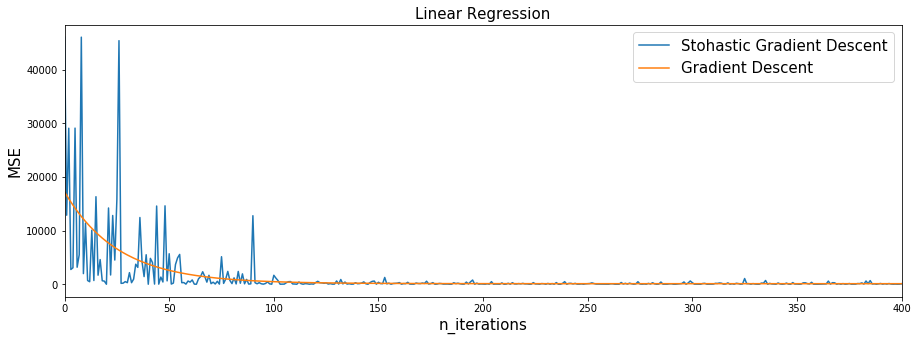

In [55]:
fig = plt.figure(figsize=(15, 5))
plt.title("Linear Regression", size=15)
plt.plot(sgd_errors_history, label="Stohastic Gradient Descent")
plt.plot(gd_errors_history, label="Gradient Descent")
plt.legend(loc="best", fontsize=15)
plt.xlabel("n_iterations", size=15)
plt.ylabel("MSE", size=15)
plt.xlim(0, 400)

## Задание 2

Модифицировать решение первого задания путем добавления $𝐿_2$-регуляризации (в функцию, считающую MSE, нужно добавить норму вектора весов) и сравнить результаты.

In [57]:
def fit_ridge_model(X: np.array,
                    y: np.array,
                    batch_size: int = 32,
                    lambda_coef: float = 0.01,
                    learning_rate: float = 0.01,
                    n_iters: int = 1000,
                    tol: float = 1e-5):
    """
    Обучение Ridge-регрессии алгоритмом градиентного спуска.

    Parameters
    ----------
    X: np.array
        Матрица признаков для обучения.

    y: np.array
        Вектор целевой переменной для обучения.

    batch_size: int, optional, default = 32
        Размер батча для одной итерации оптимизатора.
        Опциональный параметр, по умолчанию, равен 32.

    lambda_coef: float, optional, default = 0.01
        Коэффициент регуляризации.
        Опциональный параметр, по умолчанию, равен 0.01.

    learning_rate: float, optional, default = 0.01
        Скорость обучения.
        Опциональный параметр, по умолчанию, равен 0.01.

    n_iters: int, optional, default = 1000
        Количество итераций обучения. 
        Опциональный параметр, по умолчанию, равен 1000.

    tol: float, optional, default = 1e-5
        Минимальное значимое изменение ошибки, при котором
        обучение продолжается. Если изменение ошибки на соседних
        итерациях меньше указанной величины, то обучение прекращается.

    Returns
    -------
    weights: np.array
        Вектор весов линейной модели.

    weights_history: List[np.array]
        Список с векторами весов на каждой итерации обучения.

    errors_history: List[float]
        Список со значением ошибки на каждой итерации обучения.

    """
    weights = np.random.randn(X.shape[1])
    errors_history, weights_history = [], [weights]
    n_batches = len(y) // batch_size

    if len(y) % batch_size:
        n_batches += 1

    for n_iter in tqdm(range(n_iters)):
        for batch_number in range(n_batches):
            x_batch = X[batch_number*batch_size:(batch_number+1)*batch_size]
            y_batch = y[batch_number*batch_size:(batch_number+1)*batch_size]

            y_pred = np.dot(weights, x_batch.T)
            current_error = calculate_mse(y_batch, y_pred)

            weights -= 2*learning_rate*(np.sum(x_batch.T*(y_pred - y_batch), axis=1)/len(y_pred) + 2*lambda_coef*weights)
            errors_history.append(current_error)
            weights_history.append(weights)

        if n_iter > 2 and np.abs(current_error - errors_history[-2]) < 1e-4:
            break
        
    return weights, weights_history, errors_history

In [58]:
gd_ridge_weights, gd_ridge_weights_history, gd_ridge_errors_history = fit_ridge_model(
    X, y, batch_size=X.shape[0])

  0%|          | 0/1000 [00:00<?, ?it/s]


In [59]:
sgd_ridge_weights, sgd_ridge_weights_history, sgd_ridge_errors_history = fit_ridge_model(
    X, y, batch_size=1)

100%|██████████| 1000/1000 [00:49<00:00, 20.38it/s]


(0, 500)

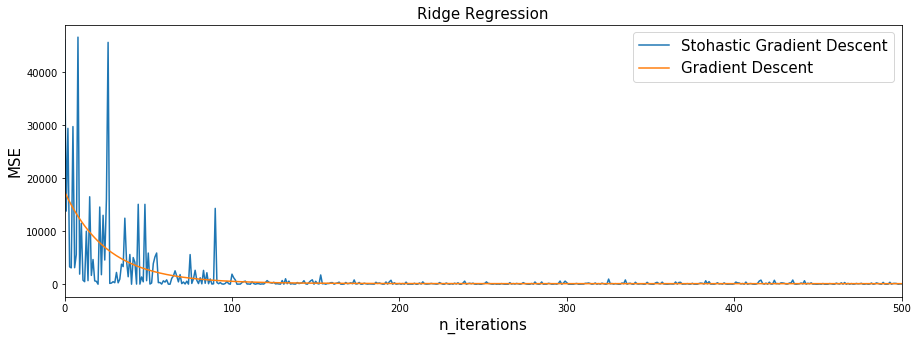

In [60]:
fig = plt.figure(figsize=(15, 5))
plt.title("Ridge Regression", size=15)
plt.plot(sgd_ridge_errors_history, label="Stohastic Gradient Descent")
plt.plot(gd_ridge_errors_history, label="Gradient Descent")
plt.legend(loc="best", fontsize=15)
plt.xlabel("n_iterations", size=15)
plt.ylabel("MSE", size=15)
plt.xlim(0, 500)

(0, 500)

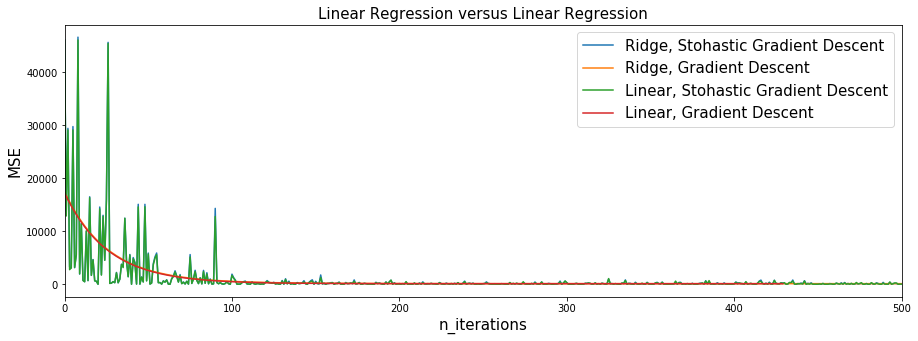

In [61]:
fig = plt.figure(figsize=(15, 5))
plt.title("Linear Regression versus Linear Regression", size=15)
plt.plot(sgd_ridge_errors_history, label="Ridge, Stohastic Gradient Descent")
plt.plot(gd_ridge_errors_history, label="Ridge, Gradient Descent")
plt.plot(sgd_errors_history, label="Linear, Stohastic Gradient Descent")
plt.plot(gd_errors_history, label="Linear, Gradient Descent")
plt.legend(loc="best", fontsize=15)
plt.xlabel("n_iterations", size=15)
plt.ylabel("MSE", size=15)
plt.xlim(0, 500)